# 📊 Aadhaar Enrolment Analysis
## UIDAI Hackathon 2026 - Lifecycle Stress & Behaviour Analysis

**Objective:** Identify enrolment saturation zones, child inclusion gaps, and regional imbalances.

---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

## 1. Data Loading & Initial Exploration

In [2]:
# Load all enrolment CSV files
data_path = Path('../data/enrolment/')
csv_files = list(data_path.glob('*.csv'))

print(f"📁 Found {len(csv_files)} CSV files in enrolment folder")
for f in csv_files:
    print(f"   - {f.name}")

# Concatenate all files
df_list = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_list.append(df_temp)
    print(f"   ✅ {file.name}: {len(df_temp):,} rows")

df = pd.concat(df_list, ignore_index=True)
print(f"\n📊 Total records loaded: {len(df):,}")

📁 Found 3 CSV files in enrolment folder
   - api_data_aadhar_enrolment_500000_1000000.csv
   - api_data_aadhar_enrolment_0_500000.csv
   - api_data_aadhar_enrolment_1000000_1006029.csv


   ✅ api_data_aadhar_enrolment_500000_1000000.csv: 500,000 rows


   ✅ api_data_aadhar_enrolment_0_500000.csv: 500,000 rows
   ✅ api_data_aadhar_enrolment_1000000_1006029.csv: 6,029 rows

📊 Total records loaded: 1,006,029


In [3]:
# Data info and first look
print("\n📋 Dataset Info:")
print("=" * 50)
print(df.info())
print("\n📊 First 5 rows:")
df.head()


📋 Dataset Info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB
None

📊 First 5 rows:


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,26-10-2025,Andhra Pradesh,Nalgonda,508004,0,1,0
1,26-10-2025,Andhra Pradesh,Nalgonda,508238,1,0,0
2,26-10-2025,Andhra Pradesh,Nalgonda,508278,1,0,0
3,26-10-2025,Andhra Pradesh,Nandyal,518432,0,1,0
4,26-10-2025,Andhra Pradesh,Nandyal,518543,1,0,0


In [4]:
# Check for missing values
print("\n🔍 Missing Values Check:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found! ✅")


🔍 Missing Values Check:


No missing values found! ✅


## 2. Data Cleaning & Transformation

In [5]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Extract time components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_year'] = df['date'].dt.to_period('M').astype(str)
df['quarter'] = df['date'].dt.quarter

# Calculate total enrolments per row
df['total_enrolment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Standardize state names (strip whitespace, title case)
df['state'] = df['state'].str.strip().str.title()
df['district'] = df['district'].str.strip().str.title()

print("✅ Data cleaned and transformed!")
print(f"\n📅 Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"🗺️ States: {df['state'].nunique()}")
print(f"🏙️ Districts: {df['district'].nunique()}")

✅ Data cleaned and transformed!

📅 Date Range: 2025-03-02 to 2025-12-31
🗺️ States: 49
🏙️ Districts: 964


In [6]:
# Summary statistics
print("\n📈 Summary Statistics:")
df[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolment']].describe()


📈 Summary Statistics:


,age_0_5,age_5_17,age_18_greater,total_enrolment
count,1.006029e+06,1.006029e+06,1.006029e+06,1.006029e+06
mean,3.525709e+00,1.710074e+00,1.673441e-01,5.403127e+00
std,1.753851e+01,1.436963e+01,3.220525e+00,3.158275e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,3.000000e+00,1.000000e+00,0.000000e+00,5.000000e+00
max,2.688000e+03,1.812000e+03,8.550000e+02,3.965000e+03


## 3. Univariate Analysis

### 3.1 Temporal Trends

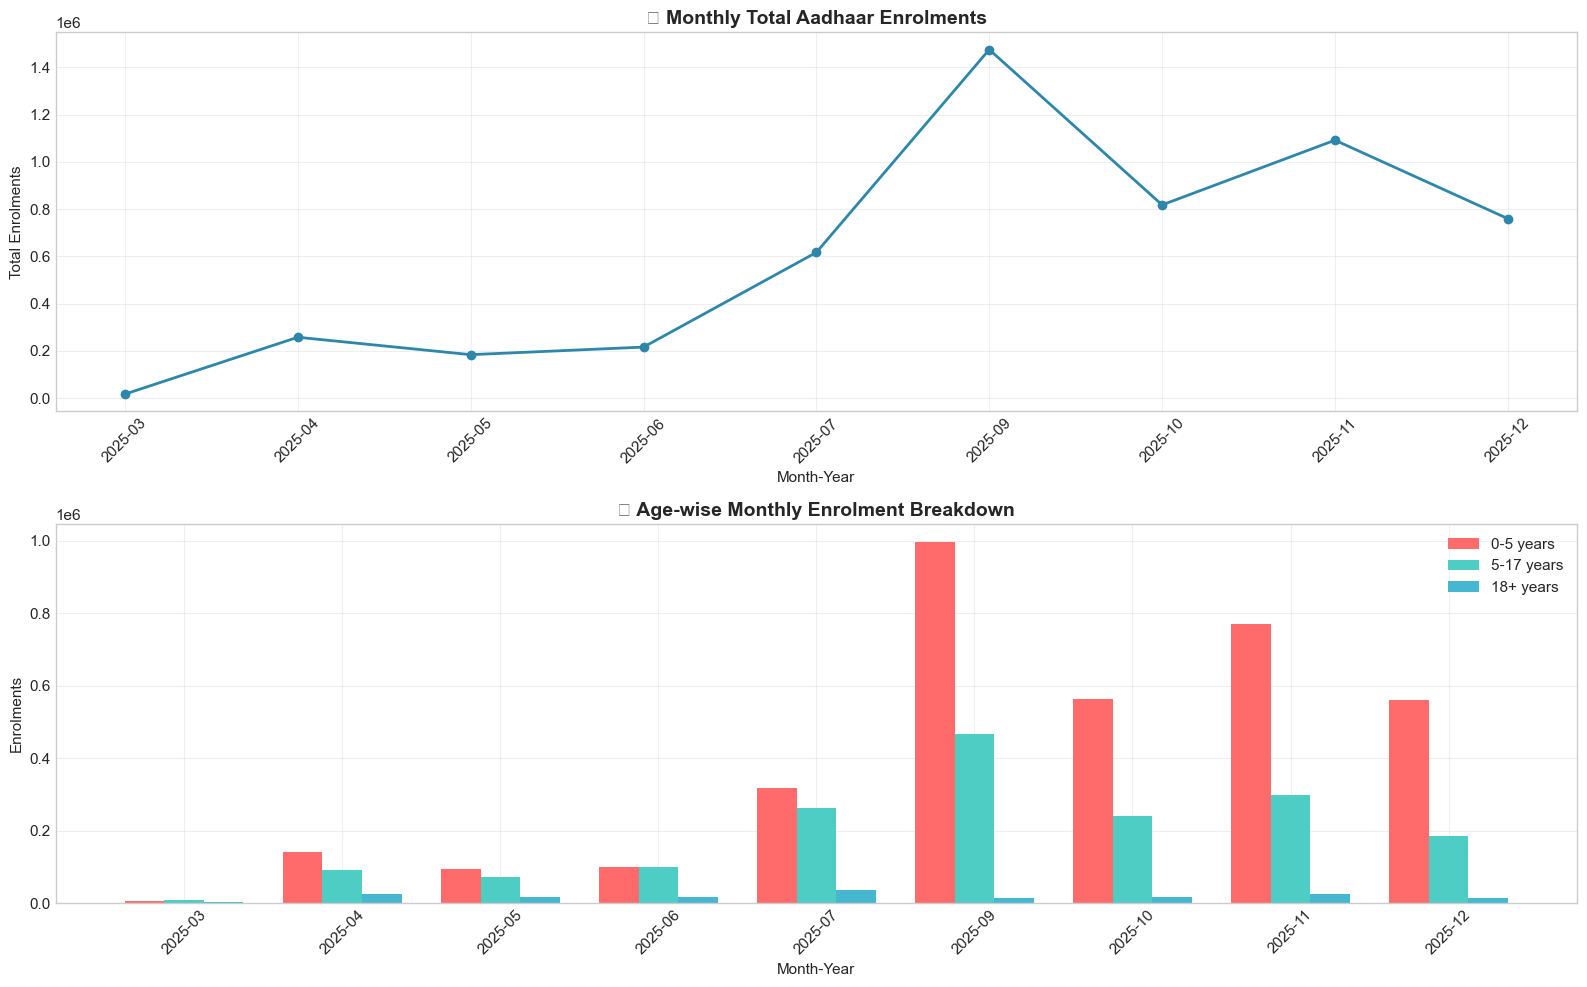


💡 INSIGHT: Check for seasonal patterns and any plateau periods.


In [7]:
# Monthly enrolment trend
monthly_trend = df.groupby('month_year').agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum', 
    'age_18_greater': 'sum',
    'total_enrolment': 'sum'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Total enrolment trend
axes[0].plot(monthly_trend['month_year'], monthly_trend['total_enrolment'], 
             marker='o', linewidth=2, markersize=6, color='#2E86AB')
axes[0].set_title('📈 Monthly Total Aadhaar Enrolments', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month-Year')
axes[0].set_ylabel('Total Enrolments')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Age group breakdown
x = range(len(monthly_trend))
width = 0.25
axes[1].bar([i-width for i in x], monthly_trend['age_0_5'], width, label='0-5 years', color='#FF6B6B')
axes[1].bar(x, monthly_trend['age_5_17'], width, label='5-17 years', color='#4ECDC4')
axes[1].bar([i+width for i in x], monthly_trend['age_18_greater'], width, label='18+ years', color='#45B7D1')
axes[1].set_title('📊 Age-wise Monthly Enrolment Breakdown', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month-Year')
axes[1].set_ylabel('Enrolments')
axes[1].set_xticks(x)
axes[1].set_xticklabels(monthly_trend['month_year'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_monthly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Check for seasonal patterns and any plateau periods.")

### 3.2 Age Group Distribution

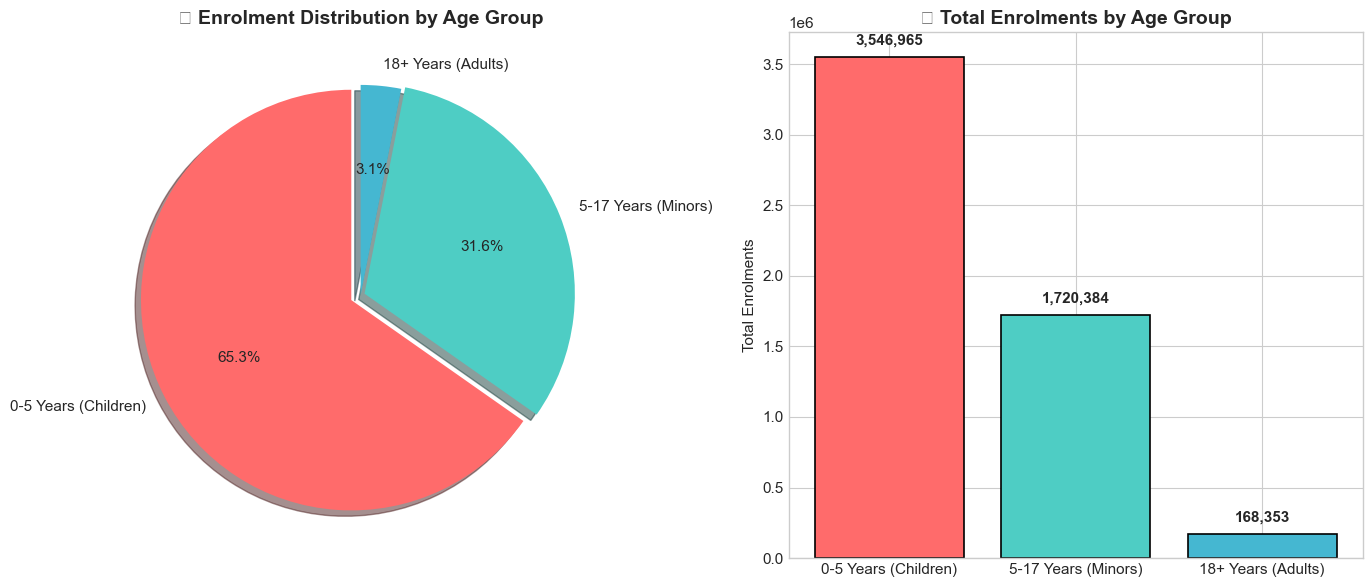


📋 Age Group Summary:
  0-5 Years (Children): 3,546,965 (65.3%)
  5-17 Years (Minors): 1,720,384 (31.6%)
  18+ Years (Adults): 168,353 (3.1%)


In [8]:
# Age group distribution
age_totals = {
    '0-5 Years (Children)': df['age_0_5'].sum(),
    '5-17 Years (Minors)': df['age_5_17'].sum(),
    '18+ Years (Adults)': df['age_18_greater'].sum()
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
explode = (0.05, 0.02, 0)
axes[0].pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%',
           colors=colors, explode=explode, shadow=True, startangle=90)
axes[0].set_title('🎯 Enrolment Distribution by Age Group', fontsize=14, fontweight='bold')

# Bar chart with values
bars = axes[1].bar(age_totals.keys(), age_totals.values(), color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_title('📊 Total Enrolments by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Enrolments')
for bar, value in zip(bars, age_totals.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*max(age_totals.values()),
                f'{value:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_age_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
total = sum(age_totals.values())
print("\n📋 Age Group Summary:")
print("=" * 50)
for group, count in age_totals.items():
    print(f"  {group}: {count:,.0f} ({count/total*100:.1f}%)")

## 4. Bivariate Analysis

### 4.1 State-wise Enrolment Analysis

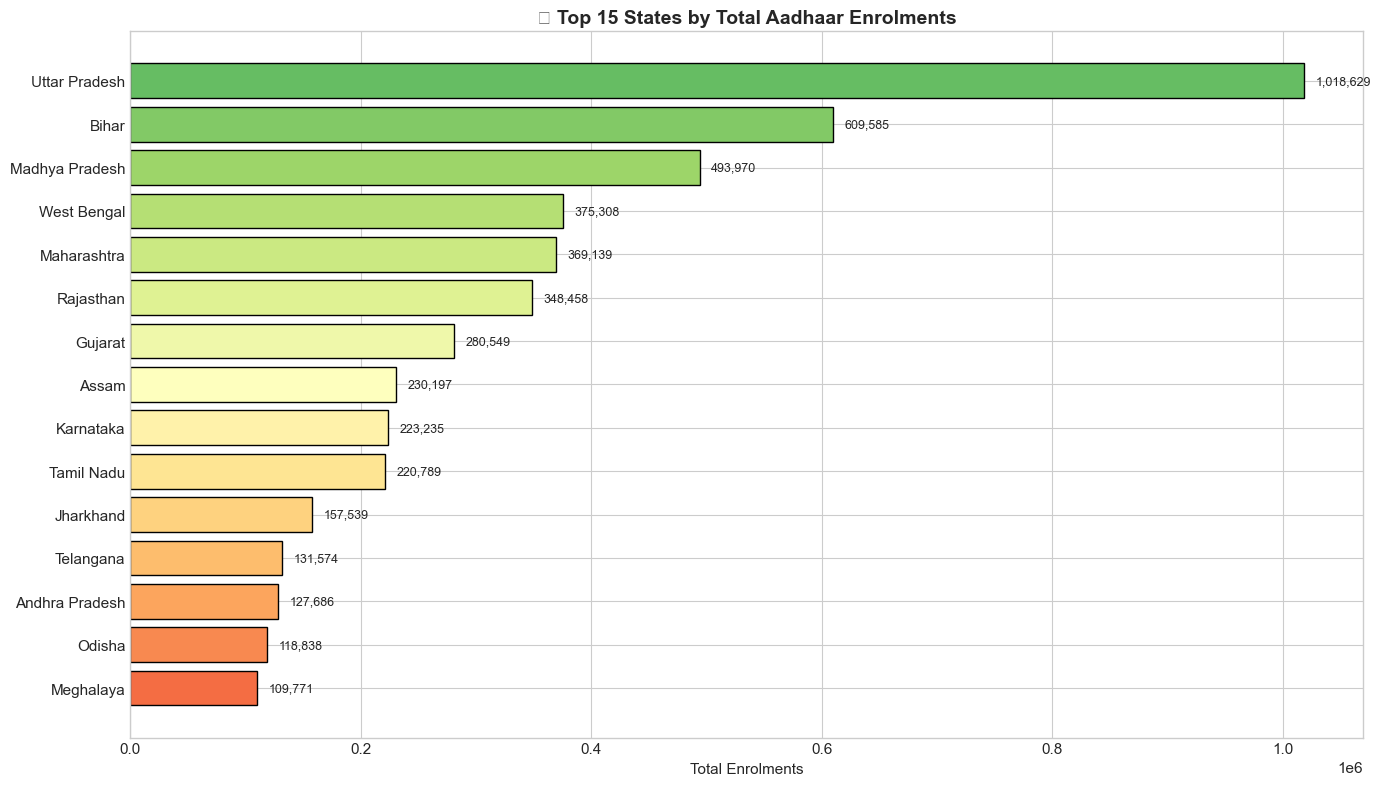

In [9]:
# State-wise total enrolments
state_enrolment = df.groupby('state').agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrolment': 'sum'
}).reset_index().sort_values('total_enrolment', ascending=False)

# Top 15 states
top_states = state_enrolment.head(15)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_states)))[::-1]

bars = ax.barh(top_states['state'], top_states['total_enrolment'], color=colors, edgecolor='black')
ax.set_xlabel('Total Enrolments')
ax.set_title('🏆 Top 15 States by Total Aadhaar Enrolments', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, value in zip(bars, top_states['total_enrolment']):
    ax.text(value + 0.01*max(top_states['total_enrolment']), bar.get_y() + bar.get_height()/2,
           f'{value:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_top_states.png', dpi=150, bbox_inches='tight')
plt.show()

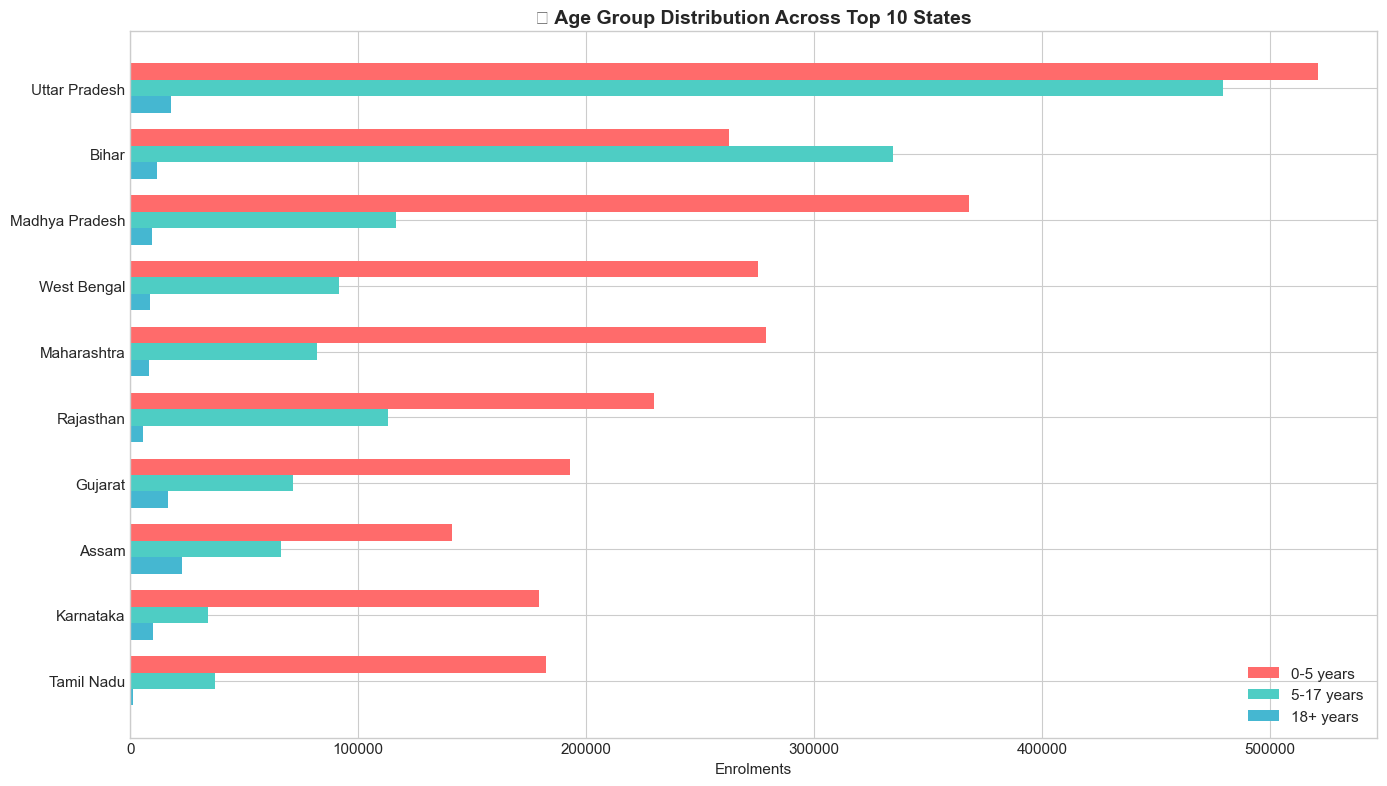

In [10]:
# State-wise age group breakdown
top_10 = state_enrolment.head(10)

fig, ax = plt.subplots(figsize=(14, 8))
x = range(len(top_10))
width = 0.25

ax.barh([i-width for i in x], top_10['age_0_5'], width, label='0-5 years', color='#FF6B6B')
ax.barh(x, top_10['age_5_17'], width, label='5-17 years', color='#4ECDC4')
ax.barh([i+width for i in x], top_10['age_18_greater'], width, label='18+ years', color='#45B7D1')

ax.set_yticks(x)
ax.set_yticklabels(top_10['state'])
ax.set_xlabel('Enrolments')
ax.set_title('📊 Age Group Distribution Across Top 10 States', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_states_age_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Child Inclusion Gap Analysis (0-5 Age Group)

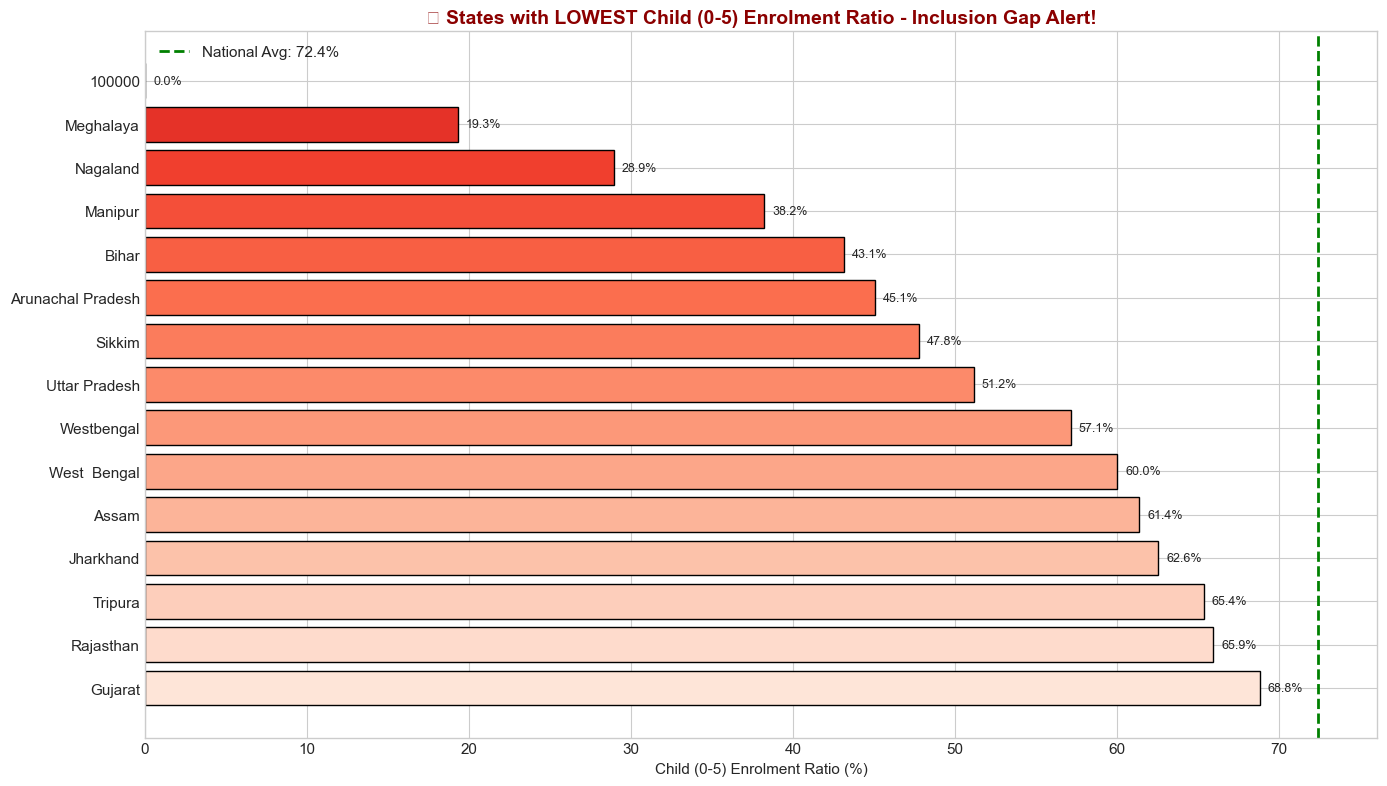


🚨 POLICY INSIGHT: These states need targeted child Aadhaar enrolment drives!
   Focus areas: Hospital-based enrolment, school outreach, Anganwadi centers


In [11]:
# Calculate child enrollment ratio
state_enrolment['child_ratio'] = (state_enrolment['age_0_5'] / state_enrolment['total_enrolment']) * 100

# States with lowest child enrolment ratio
low_child_states = state_enrolment.nsmallest(15, 'child_ratio')

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Reds_r(np.linspace(0.3, 0.9, len(low_child_states)))

bars = ax.barh(low_child_states['state'], low_child_states['child_ratio'], color=colors, edgecolor='black')
ax.set_xlabel('Child (0-5) Enrolment Ratio (%)')
ax.set_title('🚨 States with LOWEST Child (0-5) Enrolment Ratio - Inclusion Gap Alert!', 
            fontsize=14, fontweight='bold', color='darkred')
ax.invert_yaxis()
ax.axvline(x=state_enrolment['child_ratio'].mean(), color='green', linestyle='--', 
          linewidth=2, label=f"National Avg: {state_enrolment['child_ratio'].mean():.1f}%")
ax.legend()

for bar, value in zip(bars, low_child_states['child_ratio']):
    ax.text(value + 0.5, bar.get_y() + bar.get_height()/2, f'{value:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_child_inclusion_gap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🚨 POLICY INSIGHT: These states need targeted child Aadhaar enrolment drives!")
print("   Focus areas: Hospital-based enrolment, school outreach, Anganwadi centers")

## 5. Trivariate Analysis: State × Age × Time

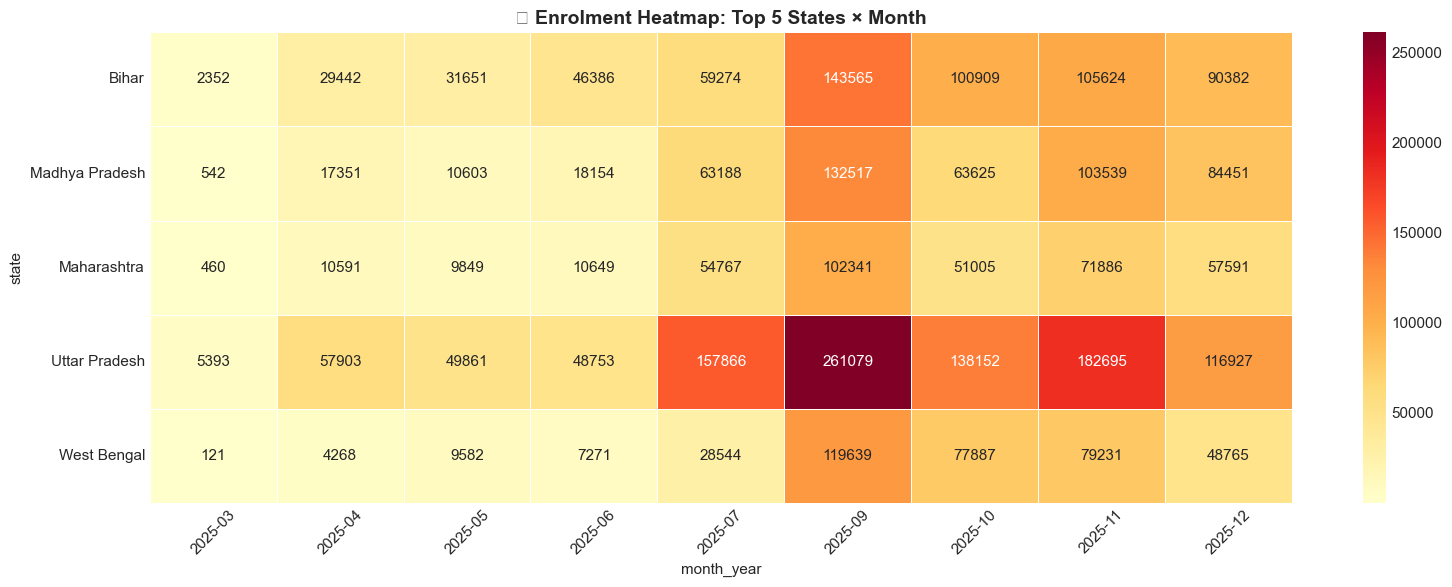

In [12]:
# Heatmap: State vs Month for Top States
top_5_states = state_enrolment.head(5)['state'].tolist()
df_top = df[df['state'].isin(top_5_states)]

pivot = df_top.pivot_table(
    values='total_enrolment', 
    index='state', 
    columns='month_year', 
    aggfunc='sum'
)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5, ax=ax)
ax.set_title('🔥 Enrolment Heatmap: Top 5 States × Month', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_heatmap_state_time.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. District-Level Imbalance Analysis

In [13]:
# District-wise analysis
district_enrolment = df.groupby(['state', 'district']).agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum'
}).reset_index()

# Top 20 districts
top_districts = district_enrolment.nlargest(20, 'total_enrolment')

print("\n🏆 TOP 20 DISTRICTS BY ENROLMENT:")
print("=" * 60)
for i, row in top_districts.iterrows():
    print(f"  {row['district']}, {row['state']}: {row['total_enrolment']:,.0f}")

# Bottom 20 districts
bottom_districts = district_enrolment.nsmallest(20, 'total_enrolment')

print("\n🚨 BOTTOM 20 DISTRICTS BY ENROLMENT (Need Attention):")
print("=" * 60)
for i, row in bottom_districts.iterrows():
    print(f"  {row['district']}, {row['state']}: {row['total_enrolment']:,.0f}")


🏆 TOP 20 DISTRICTS BY ENROLMENT:
  Thane, Maharashtra: 43,688
  Sitamarhi, Bihar: 42,232
  Bahraich, Uttar Pradesh: 39,338
  Murshidabad, West Bengal: 35,911
  South 24 Parganas, West Bengal: 33,542
  Pune, Maharashtra: 31,763
  Jaipur, Rajasthan: 31,146
  Bengaluru, Karnataka: 30,980
  Sitapur, Uttar Pradesh: 30,854
  West Champaran, Bihar: 30,438
  Agra, Uttar Pradesh: 29,910
  East Champaran, Bihar: 29,323
  Muzaffarpur, Bihar: 28,855
  East Khasi Hills, Meghalaya: 28,812
  North 24 Parganas, West Bengal: 28,606
  Bareilly, Uttar Pradesh: 27,811
  Gaya, Bihar: 27,401
  Uttar Dinajpur, West Bengal: 26,892
  Aligarh, Uttar Pradesh: 26,192
  Hyderabad, Telangana: 25,990

🚨 BOTTOM 20 DISTRICTS BY ENROLMENT (Need Attention):
  Nicobars, Andaman & Nicobar Islands: 1
  Jhajjar *, Haryana: 1
  Punch, Jammu & Kashmir: 1
  Hingoli *, Maharashtra: 1
  Kendrapara *, Orissa: 1
  Sundergarh, Orissa: 1
  Balotra, Rajasthan: 1
  Beawar, Rajasthan: 1
  Salumbar, Rajasthan: 1
  Namakkal   *, Tamil N

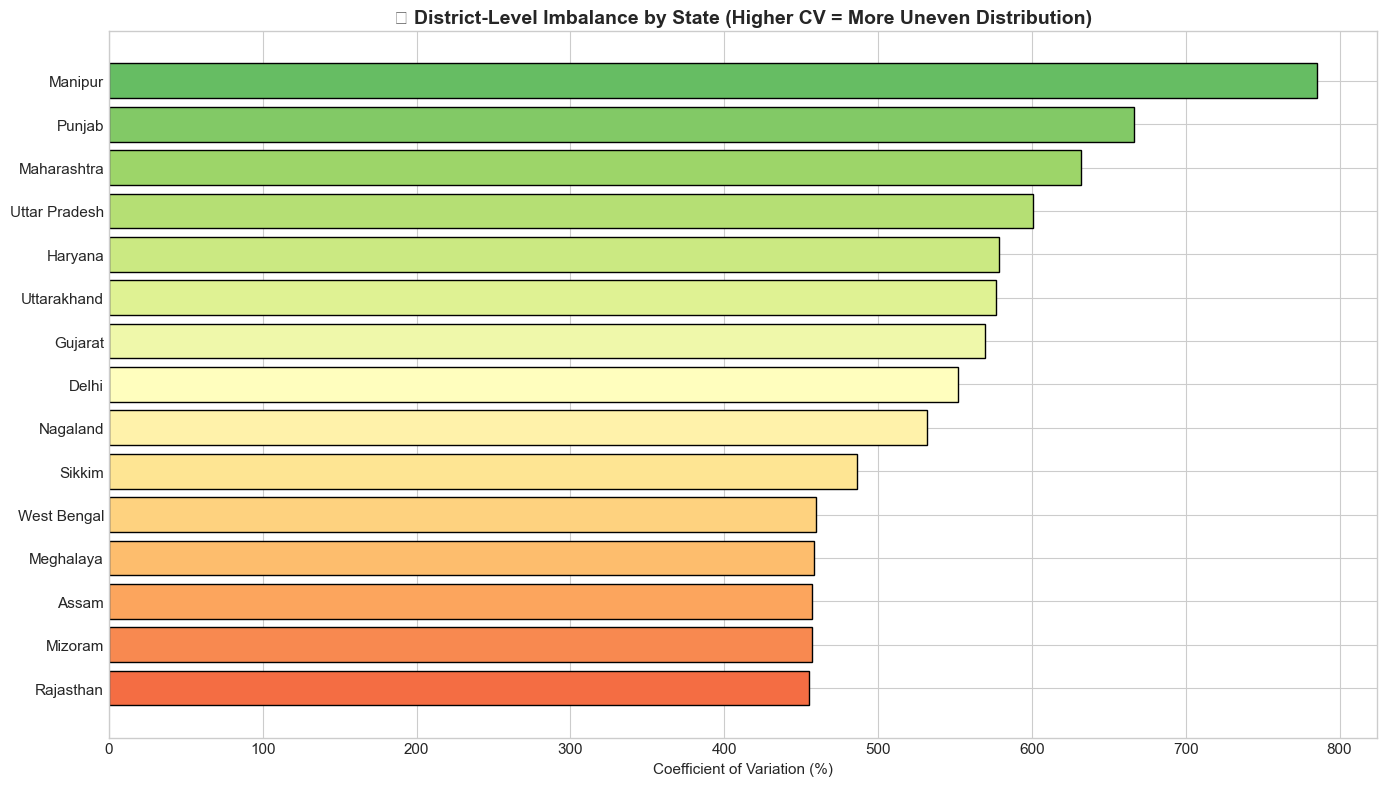


💡 INSIGHT: High CV states have district-level enrolment imbalance - need localized strategies


In [14]:
# State-wise district imbalance (coefficient of variation)
state_district_cv = df.groupby('state')['total_enrolment'].apply(
    lambda x: (x.std() / x.mean()) * 100 if x.mean() > 0 else 0
).reset_index()
state_district_cv.columns = ['state', 'cv_percent']
state_district_cv = state_district_cv.sort_values('cv_percent', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(state_district_cv)))

bars = ax.barh(state_district_cv['state'], state_district_cv['cv_percent'], color=colors, edgecolor='black')
ax.set_xlabel('Coefficient of Variation (%)')
ax.set_title('📊 District-Level Imbalance by State (Higher CV = More Uneven Distribution)', 
            fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/charts/enrolment_district_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: High CV states have district-level enrolment imbalance - need localized strategies")

## 7. Enrolment Saturation Analysis

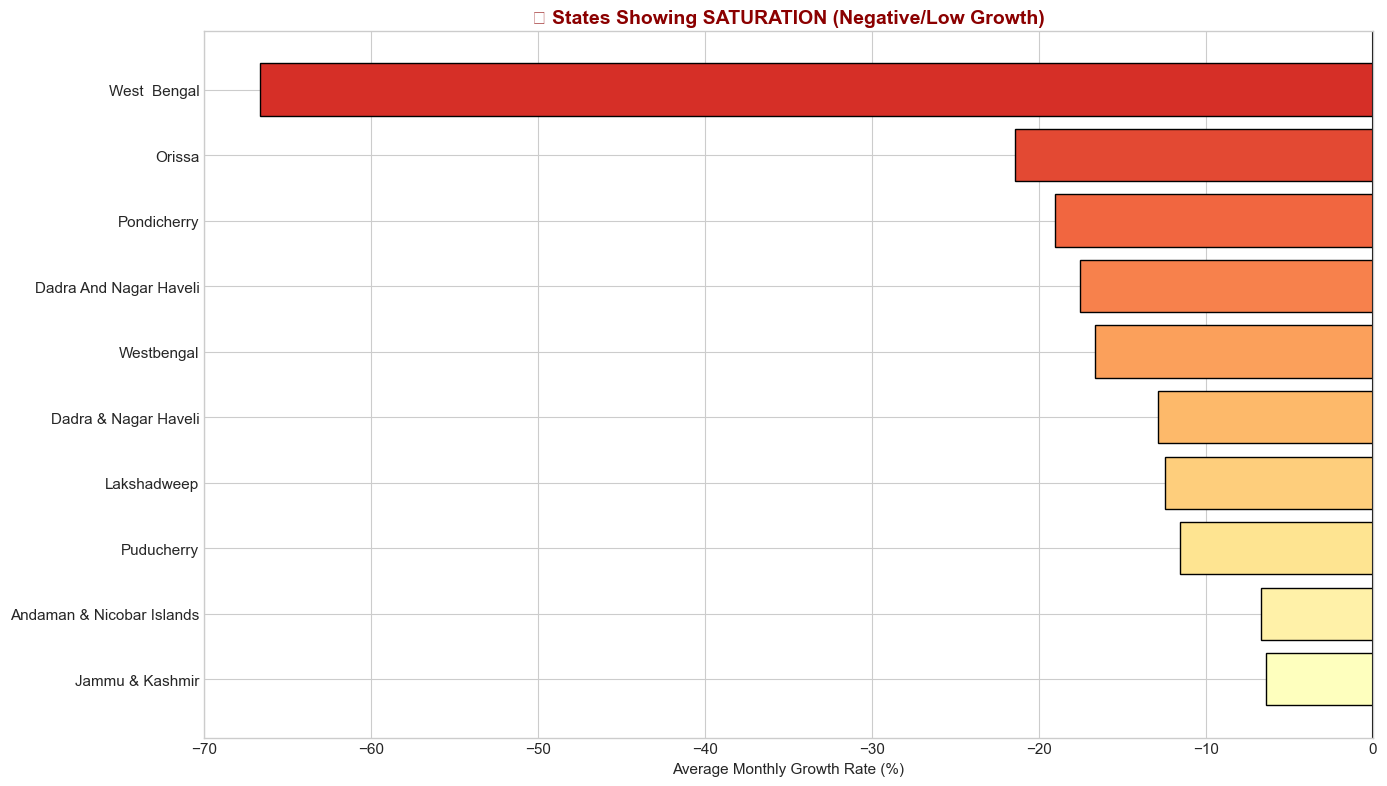


🎯 POLICY INSIGHT: These states may be approaching enrolment saturation.
   Shift focus to: Demographic updates, biometric updates, service delivery


In [15]:
# Calculate growth rate between periods
state_monthly = df.groupby(['state', 'month_year']).agg({'total_enrolment': 'sum'}).reset_index()
state_monthly = state_monthly.sort_values(['state', 'month_year'])
state_monthly['growth_rate'] = state_monthly.groupby('state')['total_enrolment'].pct_change() * 100

# Average growth by state
avg_growth = state_monthly.groupby('state')['growth_rate'].mean().reset_index()
avg_growth = avg_growth.sort_values('growth_rate')

# States with declining/stagnant growth (potential saturation)
saturated_states = avg_growth[avg_growth['growth_rate'] < 0].head(15)

if len(saturated_states) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.5, len(saturated_states)))
    
    bars = ax.barh(saturated_states['state'], saturated_states['growth_rate'], color=colors, edgecolor='black')
    ax.set_xlabel('Average Monthly Growth Rate (%)')
    ax.set_title('🛑 States Showing SATURATION (Negative/Low Growth)', fontsize=14, fontweight='bold', color='darkred')
    ax.axvline(x=0, color='black', linewidth=1.5)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('../outputs/charts/enrolment_saturation_states.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n🎯 POLICY INSIGHT: These states may be approaching enrolment saturation.")
    print("   Shift focus to: Demographic updates, biometric updates, service delivery")
else:
    print("✅ No states showing clear saturation pattern in current data.")

## 8. Summary Table Generation

In [16]:
# Create comprehensive state summary
state_summary = df.groupby('state').agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum', 
    'age_18_greater': 'sum',
    'district': 'nunique',
    'pincode': 'nunique'
}).reset_index()

state_summary.columns = ['State', 'Total_Enrolment', 'Age_0_5', 'Age_5_17', 'Age_18_Plus', 'Districts', 'Pincodes']
state_summary['Child_Ratio_%'] = (state_summary['Age_0_5'] / state_summary['Total_Enrolment'] * 100).round(1)
state_summary['Minor_Ratio_%'] = (state_summary['Age_5_17'] / state_summary['Total_Enrolment'] * 100).round(1)
state_summary['Adult_Ratio_%'] = (state_summary['Age_18_Plus'] / state_summary['Total_Enrolment'] * 100).round(1)
state_summary = state_summary.sort_values('Total_Enrolment', ascending=False)

# Save to CSV
state_summary.to_csv('../outputs/summary_tables/enrolment_state_summary.csv', index=False)
print("✅ State summary saved to outputs/summary_tables/enrolment_state_summary.csv")

# Display top states
print("\n📊 STATE-WISE ENROLMENT SUMMARY (Top 15):")
state_summary.head(15)

✅ State summary saved to outputs/summary_tables/enrolment_state_summary.csv

📊 STATE-WISE ENROLMENT SUMMARY (Top 15):


,State,Total_Enrolment,Age_0_5,Age_5_17,Age_18_Plus,Districts,Pincodes,Child_Ratio_%,Minor_Ratio_%,Adult_Ratio_%
43,Uttar Pradesh,1018629,521045,479682,17902,89,1737,51.2,47.1,1.8
6,Bihar,609585,262875,334802,11908,47,906,43.1,54.9,2.0
26,Madhya Pradesh,493970,367990,116381,9599,61,787,74.5,23.6,1.9
47,West Bengal,375308,275400,91398,8510,50,1336,73.4,24.4,2.3
27,Maharashtra,369139,278814,82116,8209,53,1580,75.5,22.2,2.2
37,Rajasthan,348458,229780,113123,5555,42,978,65.9,32.5,1.6
16,Gujarat,280549,193031,71182,16336,40,1020,68.8,25.4,5.8
5,Assam,230197,141235,66085,22877,38,571,61.4,28.7,9.9
22,Karnataka,223235,179262,33863,10110,55,1336,80.3,15.2,4.5
39,Tamil Nadu,220789,182313,37227,1249,46,2064,82.6,16.9,0.6


## 9. Key Findings & Policy Insights

In [17]:
# Generate key insights
print("\n" + "="*70)
print("📋 KEY FINDINGS - AADHAAR ENROLMENT ANALYSIS")
print("="*70)

total_enrolments = df['total_enrolment'].sum()
child_enrolments = df['age_0_5'].sum()
minor_enrolments = df['age_5_17'].sum()
adult_enrolments = df['age_18_greater'].sum()

print(f"\n✅ TOTAL ENROLMENTS: {total_enrolments:,.0f}")
print(f"   - Children (0-5): {child_enrolments:,.0f} ({child_enrolments/total_enrolments*100:.1f}%)")
print(f"   - Minors (5-17): {minor_enrolments:,.0f} ({minor_enrolments/total_enrolments*100:.1f}%)")
print(f"   - Adults (18+): {adult_enrolments:,.0f} ({adult_enrolments/total_enrolments*100:.1f}%)")

print(f"\n📍 GEOGRAPHIC COVERAGE:")
print(f"   - States/UTs: {df['state'].nunique()}")
print(f"   - Districts: {df['district'].nunique()}")
print(f"   - Pincodes: {df['pincode'].nunique()}")

# Top performing states
top_3 = state_summary.head(3)['State'].tolist()
print(f"\n🏆 TOP PERFORMING STATES: {', '.join(top_3)}")

# States needing child enrolment focus
low_child = state_summary.nsmallest(5, 'Child_Ratio_%')['State'].tolist()
print(f"\n🚨 CHILD INCLUSION GAP STATES: {', '.join(low_child)}")

print("\n" + "="*70)
print("📌 POLICY RECOMMENDATIONS:")
print("="*70)
print("""
1. CHILD ENROLMENT FOCUS:
   - Hospital-based Aadhaar enrolment at birth
   - Anganwadi center outreach programs
   - School-based enrolment drives for 0-5 age group

2. SATURATION ZONE STRATEGY:
   - Shift resources from saturated to low-coverage areas
   - Focus on demographic/biometric updates instead
   - Quality improvement over quantity

3. DISTRICT-LEVEL IMBALANCE:
   - Deploy mobile enrolment units in underserved districts
   - Partner with local administration for targeted drives
   - Real-time monitoring dashboard for district officials
""")


📋 KEY FINDINGS - AADHAAR ENROLMENT ANALYSIS

✅ TOTAL ENROLMENTS: 5,435,702
   - Children (0-5): 3,546,965 (65.3%)
   - Minors (5-17): 1,720,384 (31.6%)
   - Adults (18+): 168,353 (3.1%)

📍 GEOGRAPHIC COVERAGE:
   - States/UTs: 49
   - Districts: 964
   - Pincodes: 19463

🏆 TOP PERFORMING STATES: Uttar Pradesh, Bihar, Madhya Pradesh

🚨 CHILD INCLUSION GAP STATES: 100000, Meghalaya, Nagaland, Manipur, Bihar

📌 POLICY RECOMMENDATIONS:

1. CHILD ENROLMENT FOCUS:
   - Hospital-based Aadhaar enrolment at birth
   - Anganwadi center outreach programs
   - School-based enrolment drives for 0-5 age group

2. SATURATION ZONE STRATEGY:
   - Shift resources from saturated to low-coverage areas
   - Focus on demographic/biometric updates instead
   - Quality improvement over quantity

3. DISTRICT-LEVEL IMBALANCE:
   - Deploy mobile enrolment units in underserved districts
   - Partner with local administration for targeted drives
   - Real-time monitoring dashboard for district officials



In [18]:
# Save key metrics for combined analysis
key_metrics = {
    'total_enrolments': total_enrolments,
    'child_enrolments': child_enrolments,
    'minor_enrolments': minor_enrolments,
    'adult_enrolments': adult_enrolments,
    'states': df['state'].nunique(),
    'districts': df['district'].nunique(),
    'date_range': f"{df['date'].min().date()} to {df['date'].max().date()}"
}

pd.DataFrame([key_metrics]).to_csv('../outputs/summary_tables/enrolment_key_metrics.csv', index=False)
print("\n✅ Key metrics saved for combined analysis!")


✅ Key metrics saved for combined analysis!


---
### 📊 End of Enrolment Analysis Notebook
**Next:** Proceed to `02_demographic_analysis.ipynb`